# Tarea Gradient Boosting

Diego Lozoya Morales | 745345

# Paqueterías

In [3]:
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

# Funciones

In [4]:
def calibracion(predicciones, y_test):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y_test
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=15, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.figure()
    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o", color=colors[0])
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color=colors[1])
    plt.xlabel("Prediccion")
    plt.ylabel("Real")
    plt.title("Calibración")
    plt.legend()
    plt.show()

def loss(train_loss, test_loss):
    plt.figure()
    plt.plot(train_loss, label='train', color=colors[0])
    plt.plot(test_loss, label='test', color=colors[1])
    plt.title('Loss')
    plt.xlabel('Iteración')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def importance(features, importances, n_var, importance_type):
    model_importance = pd.DataFrame({
          'Variable': features,
          'Importancia': importances
    })
    model_importance = model_importance.sort_values(by='Importancia', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list("custom_coolwarm", [colors[1], colors[0]])
    custom_palette = sns.color_palette([cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importancia", y="Variable", data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importancia"]):
        plt.text(value + 0.002, index, f"{value:.4f}", va="center", fontsize=10)
    plt.xlabel('Importancia')
    plt.xlim(0, max(model_importance["Importancia"]) + 0.03)
    plt.ylabel('Variables')
    plt.title(f'{n_var} variables más importantes tipo {importance_type}')
    plt.show()

def lightgbm(X_train, y_train, X_test, y_test):
    model = LGBMRegressor(
        num_iterations=10000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=6,
        lambda_l2=0.1,
        subsample=0.5,
        feature_fraction=0.8,
        verbosity=-1,
        metric='rmse'
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            callbacks=[early_stopping(20),
                        log_evaluation(100)])
    
    predicciones = model.predict(X_test)
    R2 = r2_score(y_test, predicciones)
    print(f'R2: {R2:.4f}')

    calibracion(predicciones, y_test)

    train_loss = model.evals_result_['training']['rmse']
    test_loss = model.evals_result_['valid_1']['rmse']

    loss(train_loss, test_loss)

    importancia_split = model.booster_.feature_importance(importance_type='split')
    importancia_gain = model.booster_.feature_importance(importance_type='gain')
    features = model.booster_.feature_name()

    importance(features, importancia_split, 5, 'split')
    importance(features, importancia_gain, 5, 'gain')

def catboost(X_train, y_train, X_test, y_test):
    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')
    
    model = CatBoostRegressor(
        iterations=10000,           
        depth=5,                    
        learning_rate=0.1,
        subsample=0.5,              
        rsm=0.8,                    
        eval_metric='R2',           
        l2_leaf_reg=0.1,            
        random_strength=5,          
        verbose=100,
        early_stopping_rounds=20    
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_cols,
        eval_set=[(X_test, y_test)],
    )

    predicciones = model.predict(X_test)
    R2 = r2_score(y_test, predicciones)
    print(f'R2: {R2:.4f}')

    calibracion(predicciones, y_test)

    importancia = model.get_feature_importance(type='PredictionValuesChange')
    features = model.feature_names_

    importance(features, importancia, 5, 'PredictionValuesChange')

def xgboost(X_train, y_train, X_test, y_test):
    model = XGBRegressor(
        n_estimators=10000,
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.5,
        col_sample_by_tree=0.8,
        tree_method='hist'
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=20)

    predicciones = model.predict(X_test)
    R2 = r2_score(y_test, predicciones)
    print(f'R2: {R2:.4f}')

    calibracion(predicciones, y_test)

    eval_model = model.evals_result()
    train_loss = eval_model['validation_0']['rmse']
    test_loss = eval_model['validation_1']['rmse']

    loss(train_loss, test_loss)

    importancia_weight = model.get_booster().get_score(importance_type='weight')
    importancia_gain = model.get_booster().get_score(importance_type='gain')
    features = model.booster_.feature_name()

    importance(features, importancia_weight, 5, 'weight')
    importance(features, importancia_gain, 5, 'gain')

# Data

In [5]:
data = pd.read_csv("Data/Boston.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data = pd.get_dummies(data, columns=['rad'])
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


## Variable dependiente

In [6]:
target = 'medv'
y = data[target]

# Cross Validation

In [7]:
X = data.copy().drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Lightgbm

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1.78161	valid_1's rmse: 3.32032
Early stopping, best iteration is:
[90]	training's rmse: 1.88619	valid_1's rmse: 3.30426
R2: 0.8535


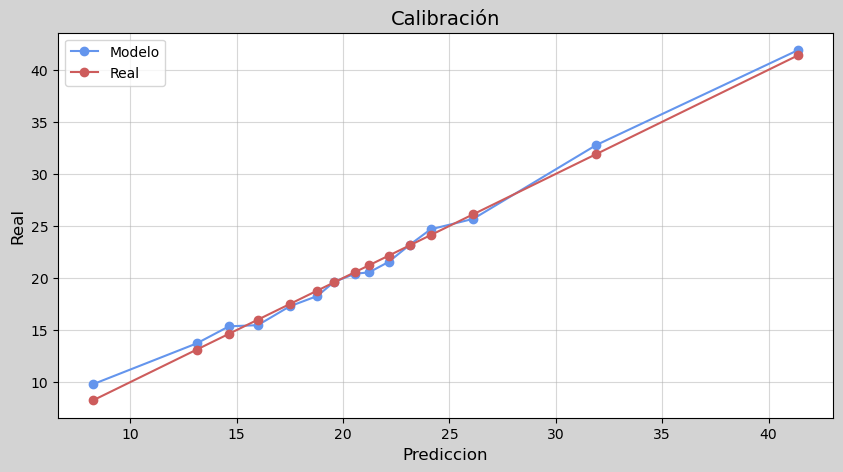

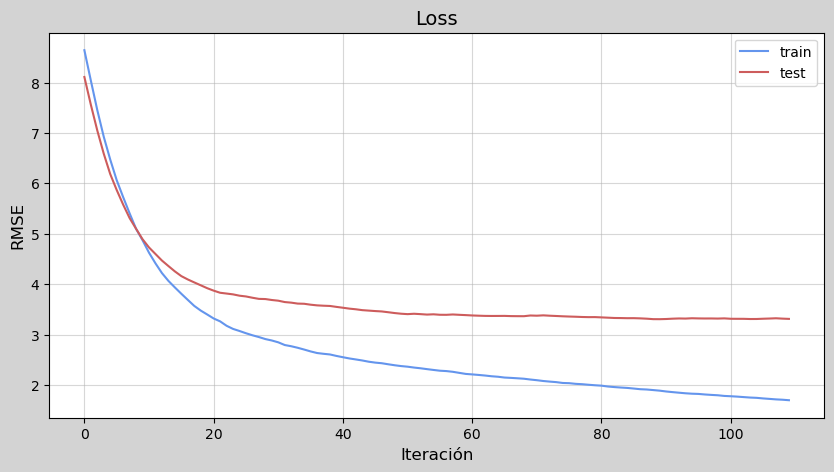

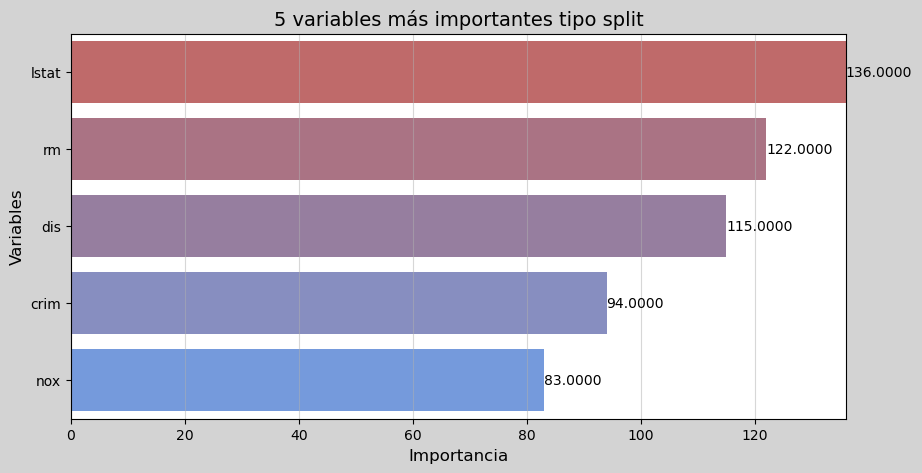

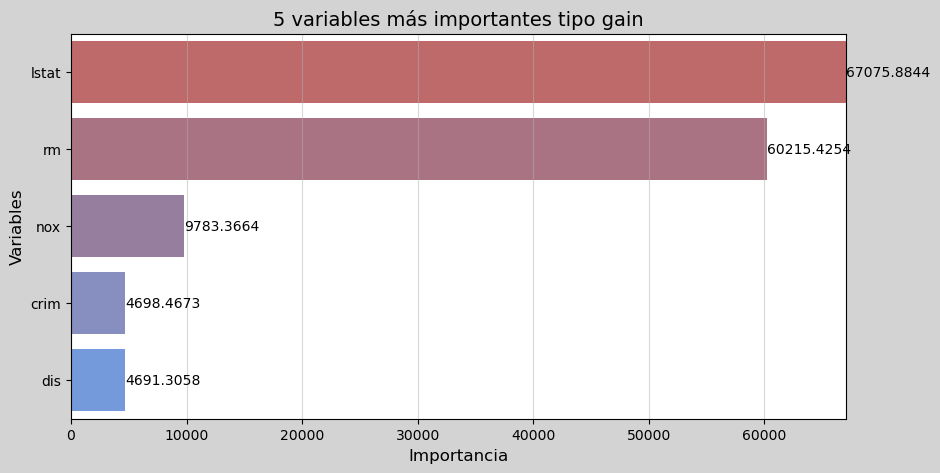

In [8]:
lightgbm(X_train, y_train, X_test, y_test)

# Catboost

0:	learn: 0.1049931	test: 0.0717690	best: 0.0717690 (0)	total: 60ms	remaining: 9m 59s
100:	learn: 0.9573610	test: 0.8537544	best: 0.8537544 (100)	total: 99.9ms	remaining: 9.79s
200:	learn: 0.9866248	test: 0.8684765	best: 0.8686302 (199)	total: 137ms	remaining: 6.67s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8699692105
bestIteration = 243

Shrink model to first 244 iterations.
R2: 0.8700


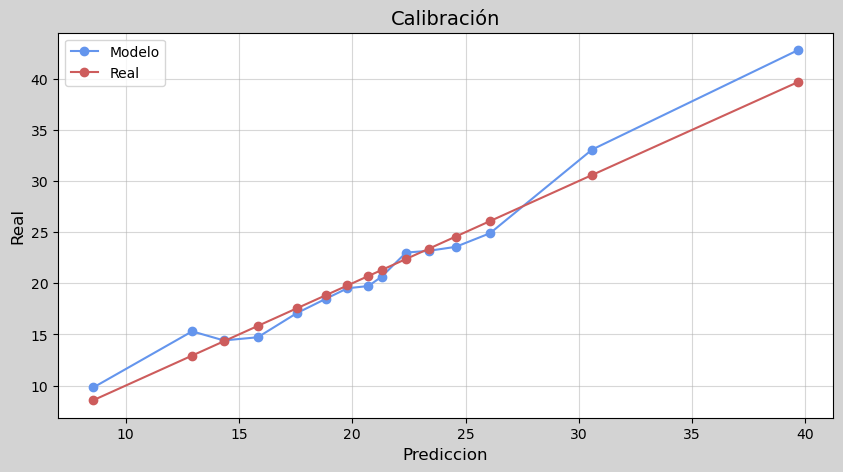

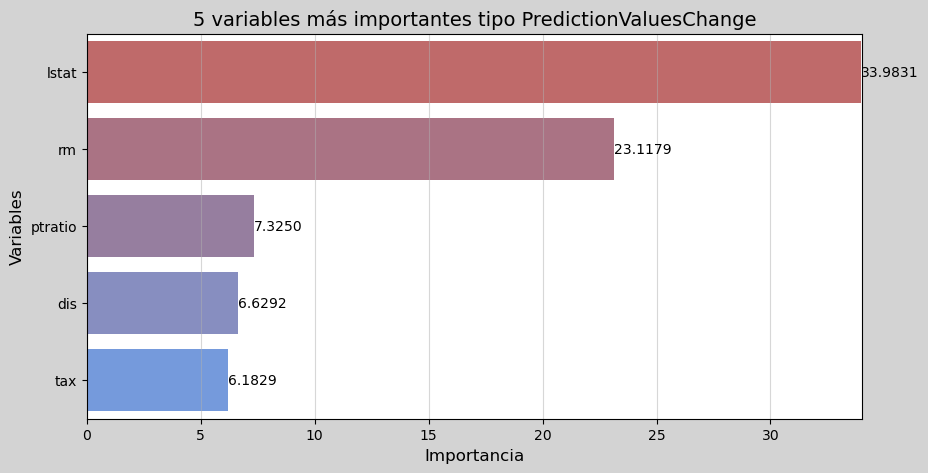

In [9]:
catboost(X_train, y_train, X_test, y_test)

# XGboost

In [10]:
xgboost(X_train, y_train, X_test, y_test)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:zn: object, chas: object, ptratio: object, rad_1: object, rad_2: object, rad_3: object, rad_4: object, rad_5: object, rad_6: object, rad_7: object, rad_8: object, rad_24: object

# Conclusiones